<a href="https://colab.research.google.com/github/leofanci/ML_works/blob/main/ML7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("ESLOY", start="1990-01-01", end="2022-02-28")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [ ]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 3
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    if train_data[i, 0] > 0:
        y_train.append(1)
    else:
        y_train.append(0)
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1), activation='sigmoid'))
model.add(LSTM(10, return_sequences=False, activation='sigmoid'))
model.add(Dense(1)) 

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
2832/2832 [==============================] - 12s 3ms/step - loss: 0.2693
Epoch 2/3
2832/2832 [==============================] - 10s 3ms/step - loss: 0.2513
Epoch 3/3
2832/2832 [==============================] - 9s 3ms/step - loss: 0.2509


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:
train_data = scaled_data[:training_data_len, :]

x_train = []
y_train = np.array(stock_data[["Close"]].pct_change().dropna())[:training_data_len, :]
for i in range(input_size, len(train_data) - (input_size - 1)):
    x_train.append(train_data[i-input_size:i, 0])

x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

y_train = y_train[input_size-1:len(x_train)+input_size-1]

in_predictions = model.predict(x_train)

89/89 [==============================] - 1s 2ms/step


In [ ]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

out_predictions = model.predict(x_test)

23/23 [==============================] - 0s 3ms/step


In [ ]:
in_sample_rmse = np.sqrt(np.mean((y_train - in_predictions)**2))
in_sample_rw_rmse = np.sqrt(np.mean((y_train[1:] - y_train[:-1])**2))

In [ ]:
out_sample_rmse = np.sqrt(np.mean((y_test - out_predictions)**2))
out_sample_rw_rmse = np.sqrt(np.mean((y_test[1:] - y_test[:-1])**2))

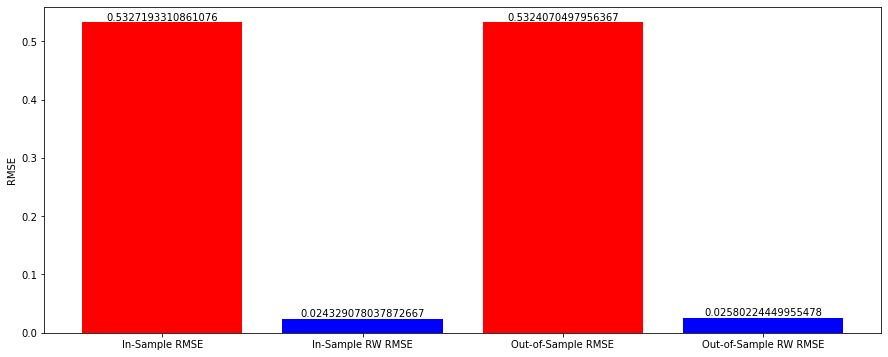

In [ ]:
import matplotlib.pyplot as plt

accuracy_scores = [in_sample_rmse, in_sample_rw_rmse, out_sample_rmse, out_sample_rw_rmse]
labels = ['In-Sample RMSE', 'In-Sample RW RMSE', 'Out-of-Sample RMSE', 'Out-of-Sample RW RMSE']
colors = ['r', 'b', 'r', 'b']

fig, ax = plt.subplots(figsize = (15,6))
ax.bar(labels, accuracy_scores, color=colors)
for i, m in enumerate(accuracy_scores):
    ax.text(i, m, str(m), ha='center', va='bottom')
ax.set_ylabel('RMSE')
plt.show()

# 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# 5.) Write an observation/conclusion about the graphs from Q4 and Q3

As we can see from the chart, the model used to predict Luxottica stock prices did not outperform the random walk. The LSTM model cannot capture any additional information in the data beyond what is captured by the random walk model. This might indicate that the market for this stock is efficient.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop

# Define the Keras model
def create_model():
    model = Sequential()
    model.add(LSTM(50, input_dim=60, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
param_grid = {'batch_size': [10, 20, 100],
              'epochs': [10, 100],
              'units': [5,10,20]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))